In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pybullet as p

from rrc.env import make_env, initializers, cube_env
from trifinger_simulation.tasks.move_cube import Pose
from rrc_iprl_package.control import controller_utils_cube as c_utils
from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d

IsaacGym not installed, FoP torch methods disabled


/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Make wrench env 

```python

env = make_env.env_fn_generator(
    diff=1, env_cls="robot_wrench_env", visualization=False, use_traj_opt=False,
    initializer='dumb_init', flatten_goal=False
)()
```

In [3]:
init = initializers.fixed_init(2)
ki = 0.1
int_freq = 10
visualization = True
traj_opt=False
path = None
use_actual_cp = True
impedance = False
object_shape = "ycb"

env = cube_env.RobotWrenchCubeEnv(
            dict(position=[0, 0, 0.05], orientation=[0, 0, 0, 1]),
            2,
            ki=ki,
            integral_control_freq=int_freq,
            visualization=visualization,
            initializer=init,
            debug=True,
            use_traj_opt=True,
            path=path,
            force_factor=1.0,
            torque_factor=0.1,
            episode_length=5000,
            use_actual_cp=use_actual_cp,
            use_impedance=impedance,
            object_shape=object_shape,
        )

/scr1/.pyenv/versions/miniconda3-latest/envs/rrc/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Helper fns

In [13]:
def set_traj_repose_object(observation, x0, x_goal, cp_params, pinocchio_utils, nGrid=50, dt=0.01):
    """Run trajectory optimization to move object given fixed contact points"""
    qnum = 3
    # Get current joint positions
    current_position = observation['position']
    # Get current fingertip positions
    current_ft_pos = pinocchio_utils.forward_kinematics(current_position)

    x_soln, dx_soln, l_wf_soln = c_utils.run_fixed_cp_traj_opt(
        cp_params,
        current_position,
        pinocchio_utils,
        x0,
        x_goal,
        nGrid,
        dt
    )

    ft_pos = np.zeros((nGrid, 9))
    ft_vel = np.zeros((nGrid, 9))

    free_finger_id = None
    for i, cp in enumerate(cp_params):
        if cp is None:
            free_finger_id = i
            break

    for t_i in range(nGrid):
        # Set fingertip goal positions and velocities from x_soln, dx_soln
        next_cube_pos_wf = x_soln[t_i, 0:3]
        next_cube_quat_wf = x_soln[t_i, 3:]

        ft_pos_list = c_utils.get_cp_pos_wf_from_cp_params(
            cp_params, next_cube_pos_wf, next_cube_quat_wf
        )

        # Hold free_finger at current ft position
        if free_finger_id is not None:
            ft_pos_list[free_finger_id] = current_ft_pos[free_finger_id]
        ft_pos[t_i, :] = np.asarray(ft_pos_list).flatten()

        # Fingertip velocities
        ft_vel_arr = np.tile(dx_soln[t_i, 0:3], 3)
        if free_finger_id is not None:
            ft_vel_arr[
                free_finger_id * qnum : free_finger_id * qnum + qnum
            ] = np.zeros(qnum)
        ft_vel[t_i, :] = ft_vel_arr

    # Add 0 forces for free_fingertip to l_wf
    l_wf = np.zeros((nGrid, 9))
    i = 0
    for f_i in range(3):
        if f_i == free_finger_id:
            continue
        l_wf[:, f_i * qnum : f_i * qnum + qnum] = l_wf_soln[
            :, i * qnum : i * qnum + qnum
        ]
        i += 1

    # Number of interpolation points
    interp_n = 26

    # Linearly interpolate between each position waypoint (row) and force waypoint
    # Initial row indices
    row_ind_in = np.arange(nGrid)
    # Output row coordinates
    row_coord_out = np.linspace(0, nGrid - 1, interp_n * (nGrid - 1) + nGrid)
    # scipy.interpolate.interp1d instance
    itp_pos = interp1d(row_ind_in, ft_pos, axis=0)
    # itp_vel = interp1d(row_ind_in, ft_vel, axis=0)
    itp_lwf = interp1d(row_ind_in, l_wf, axis=0)
    ft_pos_traj = itp_pos(row_coord_out)
    # self.ft_vel_traj = itp_vel(row_coord_out)
    l_wf_traj = itp_lwf(row_coord_out)

    # Linearly interpolate between each object pose
    # TODO: Does it make sense to linearly interpolate quaternions?
    itp_x_soln = interp1d(row_ind_in, x_soln, axis=0)
    x_traj = itp_x_soln(row_coord_out)

    # Zero-order hold for velocity waypoints
    ft_vel_traj = np.repeat(ft_vel, repeats=interp_n + 1, axis=0)[
        :-interp_n, :
    ]
    dx_traj = np.repeat(dx_soln, repeats=interp_n + 1, axis=0)[
        :-interp_n, :
    ]
    return ft_pos_traj, ft_vel_traj, l_wf_traj, x_traj, dx_traj

In [5]:
def get_grasp_ft_goal(obs):
    current_position = obs["observation"]["position"]
    current_ft_pos = obs["observation"]["tip_positions"]
    obj_pose = Pose.from_dict(obs["achieved_goal"])
    cp_wf_list = c_utils.get_cp_pos_wf_from_cp_params(env.cp_params, obj_pose.position, obj_pose.orientation)
    R_list = c_utils.get_ft_R(current_position)
    # Deal with None fingertip_goal here
    # If cp_wf is None, set ft_goal to be  current ft position
    for i in range(len(cp_wf_list)):
        if cp_wf_list[i] is None:
            cp_wf_list[i] = current_ft_pos[i]
        else:
            # Transform cp to ft center
            R = R_list[i]
            ftip_radius_pos_offset = R @ np.array([0, 0, 0.005])
            new_pos = np.array(cp_wf_list[i]) + ftip_radius_pos_offset[:3]
            cp_wf_list[i] = new_pos
    return np.concatenate(cp_wf_list)

In [6]:
def compute_joint_torques(q_curr, dq_curr, des_wrench, tip_forces_wf,
                          use_impedance=False, resist=False):
    current_ft_pos = env.pinocchio_utils.forward_kinematics(q_curr)
    (
        ft_pos_goal_list,
        ft_vel_goal_list,
        delta_dx,
        tip_jacobians,
    ) = env.get_ft_pos_vel_goals(q_curr, dq_curr, current_ft_pos, des_wrench)
    ft_vel_goal_list = np.zeros((3, 3))
    torque = np.zeros(9)
    Kp = np.array([200, 200, 400, 200, 200, 400, 200, 200, 400]) * 0.1
    Kv = np.array([7.0, 7.0, 8.0, 7.0, 7.0, 8.0, 7.0, 7.0, 8.0]) * 0.1
    if use_impedance:
        torque = c_utils.impedance_controller(
            ft_pos_goal_list,
            ft_vel_goal_list,
            q_curr,
            dq_curr,
            env.pinocchio_utils,
            tip_forces_wf=tip_forces_wf.flatten(),
            grav=env._gravity,
            Kp=Kp,
            Kv=Kv,
        )
    for fid in range(3):
        delta_x = np.expand_dims(ft_pos_goal_list[fid] - current_ft_pos[fid], 1)
        Ji = tip_jacobians[fid]
        tip_force = np.expand_dims(tip_forces_wf[fid], 1)
        _, g = env.pinocchio_utils.get_lambda_and_g_matrix(fid, q_curr, Ji, env._gravity)
        torque = (Ji.T @ tip_force).squeeze() + g.squeeze()
    return torque

In [7]:
def get_obs_forces_wf():
    obs_forces = env.update_contact_state()
    cpts = env.get_contact_points()
    forces = [(cpt.normalForce, cpt.lateralFriction1, cpt.lateralFriction2) for cpt in cpts]
    orientations = [(cpt.contactNormalOnB, cpt.lateralFrictionDir1, cpt.lateralFrictionDir2) for cpt in cpts]
    positions = [cpt.positionOnB for cpt in cpts]
    forces_wf = env.rotate_obs_force(forces, orientations)[0]
    return forces_wf

## Run episode

In [8]:
obs = env.reset()
ft_goal = get_grasp_ft_goal(env.prev_observation)
interp_n = 2
current_position = env.prev_observation['observation']['position']
current_ft_pos = env.prev_observation['observation']['tip_positions']
done = env.ik_move(current_position, current_ft_pos,
                   ft_goal, interp_n, max_steps=10)

/scr-ssd/ksrini/trifinger_simulation/python/trifinger_simulation/trifinger_platform.py:310: UserWarning: Cameras are not enabled, so images in the camera observation are not initialized.  Create `TriFingerPlatform` with `enable_cameras=True` to get rendered camera images.
  "Cameras are not enabled, so images in the camera observation"


DEBUG: ~~~~~~Executing Pre-Grasp Align~~~~~~
DEBUG: ft_pre_goal:[ 0.     0.074  0.117  0.    -0.074  0.117 -0.074  0.     0.117]
DEBUG: ft_goal:[ 0.     0.074  0.033  0.    -0.074  0.033 -0.074  0.     0.033]
DEBUG: error to goal: [0.006 0.009 0.001 0.003 0.002 0.001 0.005 0.006 0.001]
DEBUG: error to goal: [0.002 0.007 0.001 0.002 0.003 0.001 0.006 0.003 0.   ]
DEBUG: ~~~~~~Executing Pre-Grasp Reach~~~~~~
DEBUG: error to goal: [0.    0.    0.01  0.001 0.001 0.009 0.001 0.001 0.01 ]
DEBUG: ~~~~~~Executing Grasp~~~~~~
DEBUG: current_ft_pos [[-0.0006541964641109746, 0.07328417601169428, 0.03713226804153058], [0.001781707509323785, -0.07115650141659075, 0.036226059278236106], [-0.07224424367594358, -0.0013345265236779646, 0.036926334745521094]]
DEBUG: ft_goal [ 0.002  0.038  0.045  0.004 -0.036  0.045 -0.038 -0.001  0.045]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is

In [14]:
observation = env.prev_observation['observation']
cp_params = env.cp_params
pinocchio_utils = env.pinocchio_utils
initial_pose, goal_pose = env.prev_observation['achieved_goal'], env.prev_observation['desired_goal'] 
x0 = np.concatenate([initial_pose['position'], initial_pose['orientation']])[None]
x_goal = np.concatenate([goal_pose['position'], initial_pose['orientation']])[None]
ft_pos_traj, ft_vel_traj, l_wf_traj, x_traj, dx_traj = set_traj_repose_object(
    observation, x0, x_goal, cp_params, pinocchio_utils, dt=0.08)

In [182]:
while True:
    counter += 1
    t = c_utils.impedance_controller(
        ft_pos_traj[counter].reshape((3,3)),
        ft_vel_traj[counter].reshape((3,3)),
        observation['position'],
        observation['velocity'],
        pinocchio_utils,
        tip_forces_wf=l_wf_traj[counter])

    obs, _, _, _ = env._step(t)
    observation = obs['observation']

DEBUG: current step_count: 804
DEBUG: current step_count: 1005


KeyboardInterrupt: 

In [31]:
env.ki = 0.05
env.debug = False

In [10]:
env._integral, env._des_tip_force, forces_wf

AttributeError: 'RobotWrenchCubeEnv' object has no attribute '_des_tip_force'

In [ ]:
env.get_cp_wf_list(
    env.cp_params, current_pose, use_actual_cp=False)[i][0]

NameError: name 'current_pose' is not defined

In [42]:
current_pose = Pose.from_dict(env.prev_observation['achieved_goal'])
current_ft_pos = env.prev_observation['observation']['tip_positions']
# ft_goal = current_ft_pos.copy()
ft_goal = env.get_ft_goal(q_curr, current_ft_pos, current_pose)
# for i, cpt in enumerate(cpts):
#     if cpt is None:
#         ft_goal[i] = des_goals[3*i:3*i+3]
ft_goal = ft_goal.flatten()
env.visualize_markers()
env.ik_move(q_curr, current_ft_pos, ft_goal, 15)
env.visualize_markers()

DEBUG: error to goal: [0.003 0.001 0.001 0.005 0.003 0.002 0.006 0.002 0.003]
DEBUG: current step_count: 2010
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: current step_count: 2211
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]
DEBUG: current step_count: 2412
DEBUG: error to goal: [0.007 0.001 0.003 0.003 0.004 0.002 0.002 0.001 0.001]


In [ ]:
for _ in range(10):
    obs_forces = env.update_contact_state()
    cpts = env.get_contact_points()
    forces = [(cpt.normalForce, cpt.lateralFriction1, cpt.lateralFriction2) for cpt in cpts]
    orientations = [(cpt.contactNormalOnB, cpt.lateralFrictionDir1, cpt.lateralFrictionDir2) for cpt in cpts]
    positions = [cpt.positionOnB for cpt in cpts]
    forces_wf = env.rotate_obs_force(forces, orientations)[0]
    torque, des_tip_forces = env.action(np.array([0, .1, .25, 0, 0, 0]))
    # tip_forces[-1, -1] *= -1
    q_curr, dq_curr = env.prev_observation['observation']['position'], env.prev_observation['observation']['velocity']
    torque = compute_joint_torques(
        q_curr, dq_curr, np.array([0, 0, 0.5, 0, 0, 0]), des_tip_forces, use_impedance=True)
    env._step(torque)
    env.visualize_forces(positions, forces_wf, color='red')
    env.visualize_forces(positions, des_tip_forces, color='green')
    env.visualize_markers()
    env._des_tip_force, env._integral, forces_wf, des_tip_forces

In [21]:
env._current_contact_ori[0]

In [9]:
env.get_cp_of_list(
    env.cp_params,
    Pose.from_dict(env.prev_observation['achieved_goal']),
    use_actual_cp=True)

DEBUG: Obs CP List: pos ([[ 0.001  0.034  0.008]
 [ 0.006 -0.031  0.007]
 [-0.032 -0.006  0.006]]),
ori ([[ 6.470e-03  8.691e-03 -7.051e-01  7.091e-01]
 [ 6.345e-03 -4.123e-03  7.054e-01  7.088e-01]
 [ 4.676e-03 -2.279e-04  2.823e-03  1.000e+00]])
DEBUG: Des CP List: pos ([[ 0.     0.034  0.   ]
 [ 0.    -0.034  0.   ]
 [-0.034  0.     0.   ]]),
ori ([[ 0.     0.    -0.707  0.707]
 [ 0.     0.     0.707  0.707]
 [ 0.     0.     0.     1.   ]])


[(array([0.001, 0.034, 0.008]), array([ 0.006,  0.009, -0.705,  0.709])),
 (array([ 0.006, -0.031,  0.007]), array([ 0.006, -0.004,  0.705,  0.709])),
 (array([-0.032, -0.006,  0.006]),
  array([ 4.676e-03, -2.279e-04,  2.823e-03,  1.000e+00]))]

In [ ]:
J , _ =  p.calculateJacobian(14,
                             env.prev_observation['observation']['position'], 
                             env.prev_observation['observation']['velocity'],
                             f)
J 

In [5]:
env.pinocchio_utils.get_tip_link_jacobian(0, env.prev_observation['observation']['position'])

array([[-2.51349316e-01, -2.39507205e-03, -3.79584341e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.36694838e-01,  1.16816609e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.29251639e-04, -6.72268254e-03, -1.06544813e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.42002865e-01,  9.42002865e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.35604830e-01, -3.35604830e-01,
         0.00000000e+00,  0.00000000e+00,  0.000000

In [4]:
obj_pose = Pose.from_dict(env.prev_observation["achieved_goal"])
des_cp_pos = np.array([x[0] for x in env.get_cp_of_list(env.cp_params, obj_pose, env.use_actual_cp)])

In [5]:
policy = lambda obs: np.array([0,0,1., 0,0,0])

In [6]:
while not d:
    delta_x = policy(obs).copy()
    obs, r, d, i = env.step(policy(obs))

In [ ]:
tip_positions = [] 
des_tip_positions = []
n_episodes = 50
for i in range(n_episodes):
    obs = env.reset()
    obj_pose = Pose.from_dict(env.prev_observation["achieved_goal"])
    cp_list = env.get_cp_wf_list(env.cp_params, obj_pose)
    des_tip_pos = np.asarray([cp[0] for cp in cp_list])
    current_tip_pos = env.prev_observation['observation']['tip_positions']
    if np.linalg.norm(current_tip_pos - des_tip_pos) > 0.05:
        env.execute_grasp()
    des_tip_pos = np.asarray([cp[0] for cp in cp_list])
    current_tip_pos = env.prev_observation['observation']['tip_positions']        
    tip_positions.append(current_tip_pos)
    des_tip_positions.append(des_tip_pos)

In [8]:
d0, d1 = np.load('../tests/test.npz'), np.load('../tests/test_ki_0.110.npz')

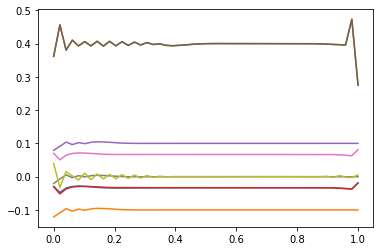

In [11]:
_, k = d0['ft_wf_traj'].shape
for i in range(k):
    plt.plot(np.linspace(0, 1, len(d0['ft_wf_traj'])), d0['ft_wf_traj'][:, i])

In [3]:
# obs = env.reset()
# current_tip_pos = env.prev_observation['observation']['tip_positions']
obj_pose = Pose.from_dict(env.prev_observation['achieved_goal'])
c_utils.get_of_from_wf(current_tip_pos, obj_pose)

array([[ 0.04404254, -0.12709241,  0.03389202],
       [-0.08708513, -0.08474551,  0.03380303],
       [ 0.02099654,  0.00797261,  0.04130636]])

(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.01453273, 0.0253115 , 0.03609027, 0.04686904, 0.05764781,
        0.06842658, 0.07920535, 0.08998412, 0.10076289, 0.11154166,
        0.12232043]),
 <BarContainer object of 10 artists>)

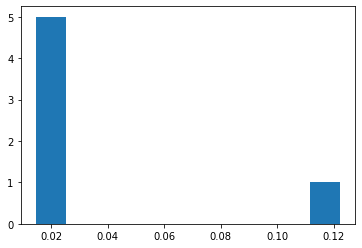

In [8]:
plt.hist([np.linalg.norm(tp - dtp) for tp, dtp in zip(tip_positions, des_tip_positions)])

(array([12.,  4., 13.,  6.,  1.,  0.,  1.,  5.,  3.,  5.]),
 array([0.01438022, 0.03261799, 0.05085577, 0.06909355, 0.08733133,
        0.10556911, 0.12380688, 0.14204466, 0.16028244, 0.17852022,
        0.196758  ]),
 <BarContainer object of 10 artists>)

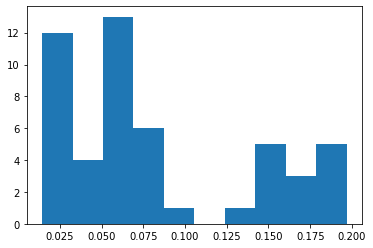

In [3]:
plt.hist([np.linalg.norm(tp - dtp) for tp, dtp in zip(tip_positions, des_tip_positions)])

(array([13.,  0.,  9., 11.,  3.,  1.,  0.,  2.,  4.,  7.]),
 array([0.01488869, 0.03052265, 0.04615661, 0.06179057, 0.07742453,
        0.09305849, 0.10869245, 0.12432641, 0.13996037, 0.15559432,
        0.17122828]),
 <BarContainer object of 10 artists>)

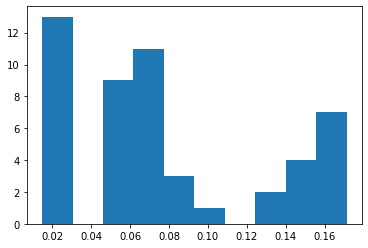

In [6]:
plt.hist([np.linalg.norm(tp - dtp) for tp, dtp in zip(tip_positions, des_tip_positions)])

(array([20.,  1.,  8.,  8.,  0.,  0.,  1.,  5.,  4.,  3.]),
 array([0.01478285, 0.03154379, 0.04830473, 0.06506568, 0.08182662,
        0.09858756, 0.1153485 , 0.13210945, 0.14887039, 0.16563133,
        0.18239227]),
 <BarContainer object of 10 artists>)

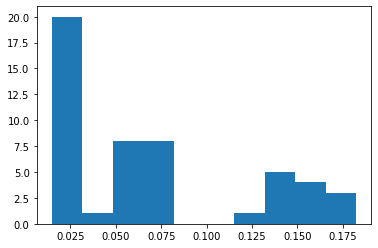

In [4]:
plt.hist([np.linalg.norm(tp - dtp) for tp, dtp in zip(tip_positions, des_tip_positions)])